#Intro

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re

In [2]:
valDF = pd.read_csv('/vaccine_validation_set.csv')
trainDF = pd.read_csv('/vaccine_train_set.csv')

In [3]:
trainDF.head()

,Unnamed: 0,tweet,label
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,1,I don't know about you but My family and I wil...,1
2,2,@MSignorile Immunizations should be mandatory....,2
3,3,President Obama spoke in favor of vaccination ...,0
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [4]:
print("validation set size:", trainDF['label'].size, "\ntraining set size:   ", valDF['label'].size) 

validation set size: 23768 
training set size:    2282


In [5]:
print(trainDF['label'].value_counts(normalize='true').to_string())

0    0.467014
2    0.401759
1    0.131227


In [6]:
count1 = trainDF['label'].isna().sum()
count2 = valDF['label'].isna().sum()
print(count1, count2)

0 0


Well, first of all, every tweet is labeled, except one in the training dataset. Let's take a closer look.

In [7]:
is_NaN = trainDF.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = trainDF[row_has_NaN]
rows_with_NaN

,Unnamed: 0,tweet,label


As we can see, there must have been some mistake in the columns since this is a pro-vax tweet. However, since the tweet is utter gibberish,  we are just going to drop it. 

In [8]:
trainDF = trainDF.dropna()

Also, we notice that there aren't many entries in the anti-vax label, something to keep in mind for later, while the only useful feature is, of course, the tweet column, so let's edit the dataset.

#Preprocessing

## Brainstorming

Let us start by examining some of the tweets.

In [9]:
from google.colab import data_table

data_table.enable_dataframe_formatter()

In [10]:
pd.DataFrame(trainDF.head(4000))

,Unnamed: 0,tweet,label
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,1,I don't know about you but My family and I wil...,1
2,2,@MSignorile Immunizations should be mandatory....,2
3,3,President Obama spoke in favor of vaccination ...,0
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0
...,...,...,...
3995,3995,How likely is it that you'll get measles? Depe...,0
3996,3996,"Busy day cleaning up, trimming hooves and vacc...",2
3997,3997,"""@CBSPhilly: Thoughts? Progressive city banish...",2
3998,3998,Walk-in vaccine available TODAY (Wednesday 4/2...,2


After reading some of the tweets and playing around with the filter options, we can find some valuable insights. One good first step would be removing all links since we have no way of understanding their content and eliminating all mentions to other accounts, i.e., anything that starts with the symbol @. Also, since we are doing sentimental analysis, removing stopwords should help minimize some of the tweets without losing any useful information. Emojis might be something else worth removing, although they may prove helpful in understanding the class of some tweets, so that might be worth examining. And finally, hashtags seem to be a pretty robust feature for determining the label of a tweet. A tweet with #VaccinateYourKids, #damnantivaxxers, #VaccinesWork, or #VaccineAccess is almost definitely a pro-vax tweet. On the other hand, #NoVaccineNeeded or #VAXTRUTH hashtags push us towards an anti-vax tweet, so something to keep in mind as well.

So, there are many exciting ideas, but we should keep it simple and start with a standard preprocessing of the data. Then we can use its results as a baseline.

##First simple steps

First, let's remove all the mentions and links from the dataset. Also, we should remove any punctuation and make all the characters lower case.

In [11]:
def regex_time(tweet):
  # In case we want to test that regex performs as we think.
  temp = re.sub(r'\s*@\S*', '', tweet)
  temp = re.sub(r'http\S+', '', temp)
  temp = re.sub(r'[\[\]\|\%\…\*\$\/\,\~\“\”\!\?\;\:\.\\"\'\(\)\-\&\\]', '', temp)

  # if(temp != tweet):
  #   print('\n')
  #   print(tweet)
  # print(temp)

  return temp

trainDF['tweet'] = trainDF['tweet'].apply(regex_time).str.lower()
valDF['tweet'] = valDF['tweet'].apply(regex_time).str.lower()

Next step, **tokenization**.

There is a wide variety of tokenizers available, each handling punctuation, emojis, and hashtags differently. 

We will try a few tokenizers suggested here https://neptune.ai/blog/tokenization-in-nlp[link text](https://) on some hand-picked tweets to see what each tokenizer has to offer.

In [12]:
sample = [trainDF.tweet[0], trainDF.tweet[9], trainDF.tweet[80], trainDF.tweet[2484], trainDF.tweet[2476],  "Im I'm im i'm don't dont do not "]

In [13]:
from nltk.tokenize import (word_tokenize,
                           TreebankWordTokenizer,
                           wordpunct_tokenize,
                           TweetTokenizer,
                          )
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
treeTokenizer=TreebankWordTokenizer()
tweetTokenizer=TweetTokenizer()

for sent in sample:
  print(sent)
  print(word_tokenize(sent))
  print(treeTokenizer.tokenize(sent))
  print(tweetTokenizer.tokenize(sent))

  print('\n')

sip n shop come thru right now #marjais #popularnobodies #mmr 🙌🙌🙌🙌 marjais sipnshop 
['sip', 'n', 'shop', 'come', 'thru', 'right', 'now', '#', 'marjais', '#', 'popularnobodies', '#', 'mmr', '🙌🙌🙌🙌', 'marjais', 'sipnshop']
['sip', 'n', 'shop', 'come', 'thru', 'right', 'now', '#', 'marjais', '#', 'popularnobodies', '#', 'mmr', '🙌🙌🙌🙌', 'marjais', 'sipnshop']
['sip', 'n', 'shop', 'come', 'thru', 'right', 'now', '#marjais', '#popularnobodies', '#mmr', '🙌', '🙌', '🙌', 'marjais', 'sipnshop']


 on average people who complain live longer  releasing this tension increases immunity and boosts their health yeah tca f u
['on', 'average', 'people', 'who', 'complain', 'live', 'longer', 'releasing', 'this', 'tension', 'increases', 'immunity', 'and', 'boosts', 'their', 'health', 'yeah', 'tca', 'f', 'u']
['on', 'average', 'people', 'who', 'complain', 'live', 'longer', 'releasing', 'this', 'tension', 'increases', 'immunity', 'and', 'boosts', 'their', 'health', 'yeah', 'tca', 'f', 'u']
['on', 'average', 'p

As we can see, there doesn't seem to be any difference between the first two tokenizers. However, the tweet tokenizer can tokenize emojis and preserve hashtags. Therefore we will use that for the time being.

Next, we could try lemmatization, stemming the tweets, or removing stopwords, but let's save that for later experimentation.

The final step is to separate the feature and the label columns, divide them into train and test datasets and finally create our first basic model.

In [15]:
preprocessedTrainX = trainDF.tweet
preprocessedValX = valDF.tweet

trainY = trainDF.label.astype(int)
valY = valDF.label.astype(int)

# The most **basic** model

##Micromanagement

For our first model, let's use a simple BOW. We will leave max and min dfs at their default values and use unigrams, at least for now. The only arguments we want to change are the tokenizer and token_pattern to allow hashtags and emojis.

In [16]:
vectorizer = CountVectorizer(token_pattern=r'(?u)\b#*\w\w+\b', tokenizer=tweetTokenizer.tokenize)
trainX = vectorizer.fit_transform(preprocessedTrainX)
valX = vectorizer.transform(preprocessedValX)

In [17]:
pd.DataFrame.from_dict(vectorizer.vocabulary_, orient='index')

,0
sip,18745
n,14799
shop,18586
come,7597
thru,20168
...,...
loldefinitely,13570
demoralize,8576
submits,19462
nutcases,15243


It's not... great. We have left numbers undisturbed, and they are not going to provide any insights. The same thing for stopwords like be, I, can, do e.t.c. Finally, it would improve performance and accuracy to remove features with low or very high frequency using the min max dfs. But it will suffice for now.

In [18]:
BasicBow = LogisticRegression(random_state=0, multi_class='multinomial').fit(trainX, trainY)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


The model reached the default of 100 maximum iterations before converging. Since it only took a second to train we can raise the number of iterations to 1000

In [19]:
BasicBow = LogisticRegression(random_state=0, multi_class='multinomial', max_iter=1000).fit(trainX, trainY)

No warning this time, lets see the accuracy then. Since there is some imbalance we will use the weighted average.

##Results

In [20]:
def scoring(trainX, trainY, valX, valY, model):
  predY = model.predict(trainX)
  precScore = precision_score(trainY, predY, average='weighted')
  f1Score = f1_score(trainY, predY, average='weighted')
  recallScore = recall_score(trainY, predY, average='weighted')

  print("Training dataset scores: \n  Precision score: {}\n  F1 score: {}\n  Recall score: {}\n".format(precScore,f1Score,recallScore))

  predY = model.predict(valX)
  precScore = precision_score(valY, predY, average='weighted')
  f1Score = f1_score(valY, predY, average='weighted')
  recallScore = recall_score(valY, predY, average='weighted')

  print("Validation dataset scores: \n  Precision score: {}\n  F1 score: {}\n  Recall score: {}\n".format(precScore,f1Score,recallScore))

In [21]:
scoring(trainX, trainY, valX, valY, BasicBow)

Training dataset scores: 
  Precision score: 0.9522668878137337
  F1 score: 0.951889976767341
  Recall score: 0.9519942780208684

Validation dataset scores: 
  Precision score: 0.6910948198563496
  F1 score: 0.6922981057821319
  Recall score: 0.6950043821209465



Well, that's pretty good. As we can see, there is a big gap between the train and the test scores, which means that the model is quite possibly overfitting, and thus, a decrease in the number of iterations would prove helpful. Nevertheless, the next step is to create the learning curves to better understand what steps to take.

First, let's split the training set. We want to start with a 10% sample and go steadily with a 10% or maybe more if it seems to take too much time.

In [22]:
def learning_curves(trainX, trainY, valX, valY, model, start, step):
  sample_size = start
  trainScores = {}
  valScores = {}
  
  while sample_size < 1.0-step:
    tempX, _, tempY, _ = train_test_split(trainX, trainY, shuffle=True, stratify = trainY, random_state=44, train_size = sample_size)
    tempModel = model.fit(tempX, tempY)

    trainPred = model.predict(tempX)
    valPred = model.predict(valX)

    trainScores[sample_size] = f1_score(tempY, trainPred, average='weighted')
    valScores[sample_size] = f1_score(valY, valPred, average='weighted')
    sample_size = sample_size + step

  tempModel = model.fit(trainX, trainY)

  trainPred = model.predict(trainX)
  valPred = model.predict(valX)

  trainScores[1.0] = f1_score(trainY, trainPred, average='weighted')
  valScores[1.0] = f1_score(valY, valPred, average='weighted')

  trainScores_list = trainScores.items()
  valScores_list = valScores.items()

  tr_x, tr_y = zip(*trainScores_list) 
  val_x, val_y = zip(*valScores_list) 

  plt.plot(val_x, val_y, tr_x, tr_y)
  plt.ylabel('F1 score')
  plt.xlabel('Training set percentage')
  plt.axis([0, 1.0, 0, 1.0])
  plt.show()


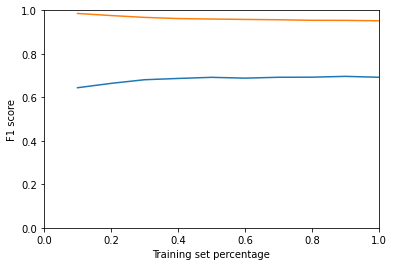

In [23]:
learning_curves(trainX, trainY, valX, valY, BasicBow, 0.1, 0.1)

As expected, the model is overfitting. We don't have any more data to feed it, stemming, removing stopwords, or changing the max and min dfs probably won't make a significant difference. Thus, we'll examine how a simple TFIDFVectorizer handles the dataset first and continue depending on the results.

Training dataset scores: 
  Precision score: 0.8696948706265062
  F1 score: 0.864592764607175
  Recall score: 0.8679316728374284

Validation dataset scores: 
  Precision score: 0.7047654171801857
  F1 score: 0.7026177235015232
  Recall score: 0.7077125328659071



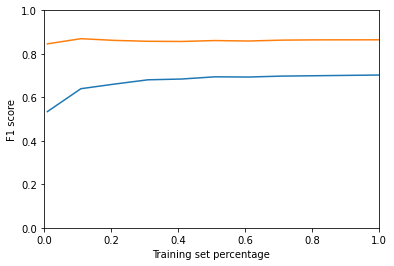

In [24]:
TFIDF = TfidfVectorizer(token_pattern=r'(?u)\b#*\w\w+\b', tokenizer=tweetTokenizer.tokenize)

trainX = TFIDF.fit_transform(preprocessedTrainX)
valX = TFIDF.transform(preprocessedValX)

BasicTFIDF = LogisticRegression(random_state=0, multi_class='multinomial', max_iter=300).fit(trainX, trainY)
scoring(trainX, trainY, valX, valY, BasicTFIDF)

learning_curves(trainX, trainY, valX, valY, BasicTFIDF, 0.01, 0.1)

Better, by a bit, but still. However, after 0.6% of the dataset, the validation score problematically stagnates. And thus, our beloved model kindly both over and under fits. Great. Well, let's see what effect a few changes on the vectorizer and the model will have.

Training dataset scores: 
  Precision score: 0.8137589645913605
  F1 score: 0.8044536874027616
  Recall score: 0.8115112756647593

Validation dataset scores: 
  Precision score: 0.7057641901135037
  F1 score: 0.7011340494029535
  Recall score: 0.7090271691498685



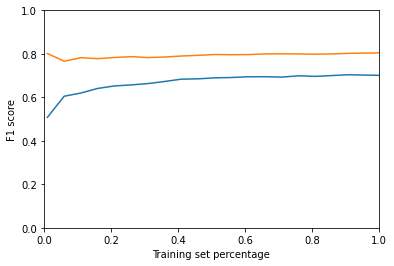

In [25]:
TFIDF = TfidfVectorizer(token_pattern=r'(?u)\b#*\w\w+\b', tokenizer=tweetTokenizer.tokenize, min_df=0.0001)

trainX = TFIDF.fit_transform(preprocessedTrainX)
valX = TFIDF.transform(preprocessedValX)

BasicTFIDF = LogisticRegression(random_state=0,  multi_class='multinomial', max_iter=100, C=0.5, tol=1e-6, solver='newton-cg').fit(trainX, trainY)
scoring(trainX, trainY, valX, valY, BasicTFIDF)

learning_curves(trainX, trainY, valX, valY, BasicTFIDF, 0.01, 0.05)

Training dataset scores: 
  Precision score: 0.8970042351298035
  F1 score: 0.8955178497093806
  Recall score: 0.8963312016156176

Validation dataset scores: 
  Precision score: 0.6972826774228775
  F1 score: 0.6981724526164839
  Recall score: 0.7007011393514461



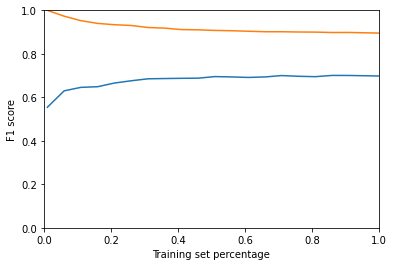

In [26]:
TFIDF = TfidfVectorizer(token_pattern=r'(?u)\b#*\w\w+\b', tokenizer=tweetTokenizer.tokenize, min_df=0.0001)

trainX = TFIDF.fit_transform(preprocessedTrainX)
valX = TFIDF.transform(preprocessedValX)

BasicTFIDF = LogisticRegression(random_state=0,  multi_class='multinomial', max_iter=100, C=3, tol=1e-6, solver='newton-cg').fit(trainX, trainY)
scoring(trainX, trainY, valX, valY, BasicTFIDF)

learning_curves(trainX, trainY, valX, valY, BasicTFIDF, 0.01, 0.05)

Playing around with the min df argument of the vectorizer and with the regulation strength seems only to lower the training accuracy but hardly changes the validation score. In other words, we can prevent some overfitting or gain some slight increase in validation accuracy.

Training dataset scores: 
  Precision score: 0.9329106623528194
  F1 score: 0.93059301053672
  Recall score: 0.9315045439246045

Validation dataset scores: 
  Precision score: 0.7336569245287851
  F1 score: 0.7263704581339451
  Recall score: 0.731375985977213



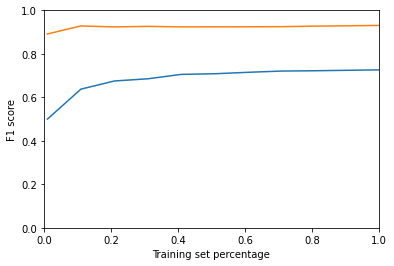

In [27]:
TFIDF = TfidfVectorizer(token_pattern=r'(?u)\b#*\w\w+\b', tokenizer=tweetTokenizer.tokenize, min_df=0.0001, ngram_range=(1,3))

trainX = TFIDF.fit_transform(preprocessedTrainX)
valX = TFIDF.transform(preprocessedValX)

BasicTFIDF = LogisticRegression(random_state=0,  multi_class='multinomial', max_iter=200, C=1.2, solver='newton-cg').fit(trainX, trainY)
scoring(trainX, trainY, valX, valY, BasicTFIDF)

learning_curves(trainX, trainY, valX, valY, BasicTFIDF, 0.01, 0.1)

Adding ngrams significantly raises the training accuracy but also the validation score. Ngrams make sense since considering the context of a word can substantially change its meaning, especially in our case, since tweets may quote other tweets sarcastically or disagree.  While both anti-vax and pro-vax groups will use the same words in a different context while 'debating'. Moreover, using ngrams increases the complexity of the model, as we have more features, making the model more vulnerable to overfitting. However, since the validation score keeps rising, I believe it's worth the risk up to a point, of course. So we have decided on a model. Below is the last cell where all the pipeline has been rewritten from start to finish.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Training dataset scores: 
  Precision score: 0.9329106623528194
  F1 score: 0.93059301053672
  Recall score: 0.9315045439246045

Validation dataset scores: 
  Precision score: 0.7336569245287851
  F1 score: 0.7263704581339451
  Recall score: 0.731375985977213



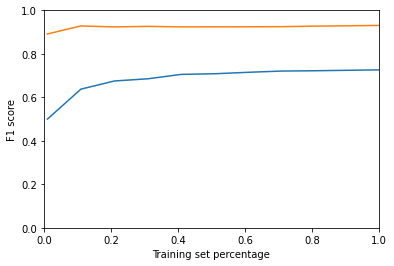

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from nltk.tokenize import TweetTokenizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re


nltk.download('punkt')

def regex_time(tweet):
  # In case we want to test that regex performs as we think.
  temp = re.sub(r'\s*@\S*', '', tweet)
  temp = re.sub(r'http\S+', '', temp)
  temp = re.sub(r'[\[\]\|\%\…\*\$\/\,\~\“\”\!\?\;\:\.\\"\'\(\)\-\&\\]', '', temp)

  # if(temp != tweet):
  #   print('\n')
  #   print(tweet)
  # print(temp)

  return temp


def scoring(trainX, trainY, valX, valY, model):
  predY = model.predict(trainX)
  precScore = precision_score(trainY, predY, average='weighted')
  f1Score = f1_score(trainY, predY, average='weighted')
  recallScore = recall_score(trainY, predY, average='weighted')

  print("Training dataset scores: \n  Precision score: {}\n  F1 score: {}\n  Recall score: {}\n".format(precScore,f1Score,recallScore))

  predY = model.predict(valX)
  precScore = precision_score(valY, predY, average='weighted')
  f1Score = f1_score(valY, predY, average='weighted')
  recallScore = recall_score(valY, predY, average='weighted')

  print("Validation dataset scores: \n  Precision score: {}\n  F1 score: {}\n  Recall score: {}\n".format(precScore,f1Score,recallScore))


def learning_curves(trainX, trainY, valX, valY, model, start, step):
  sample_size = start
  trainScores = {}
  valScores = {}
  
  while sample_size < 1.0-step:
    tempX, _, tempY, _ = train_test_split(trainX, trainY, shuffle=True, stratify = trainY, random_state=44, train_size = sample_size)
    tempModel = model.fit(tempX, tempY)

    trainPred = model.predict(tempX)
    valPred = model.predict(valX)

    trainScores[sample_size] = f1_score(tempY, trainPred, average='weighted')
    valScores[sample_size] = f1_score(valY, valPred, average='weighted')
    sample_size = sample_size + step

  tempModel = model.fit(trainX, trainY)

  trainPred = model.predict(trainX)
  valPred = model.predict(valX)

  trainScores[1.0] = f1_score(trainY, trainPred, average='weighted')
  valScores[1.0] = f1_score(valY, valPred, average='weighted')

  trainScores_list = trainScores.items()
  valScores_list = valScores.items()

  tr_x, tr_y = zip(*trainScores_list) 
  val_x, val_y = zip(*valScores_list) 

  plt.plot(val_x, val_y, tr_x, tr_y)
  plt.ylabel('F1 score')
  plt.xlabel('Training set percentage')
  plt.axis([0, 1.0, 0, 1.0])
  plt.show()


valDF = pd.read_csv('/vaccine_validation_set.csv')
trainDF = pd.read_csv('/vaccine_train_set.csv')

trainDF = trainDF.dropna()
valDF = valDF.dropna()

trainDF['tweet'] = trainDF['tweet'].apply(regex_time).str.lower()
valDF['tweet'] = valDF['tweet'].apply(regex_time).str.lower()

tweetTokenizer=TweetTokenizer()

preprocessedTrainX = trainDF.tweet
preprocessedValX = valDF.tweet

trainY = trainDF.label.astype(int)
valY = valDF.label.astype(int)

TFIDF = TfidfVectorizer(token_pattern=r'(?u)\b#*\w\w+\b', tokenizer=tweetTokenizer.tokenize, min_df=0.0001, ngram_range=(1,3))

trainX = TFIDF.fit_transform(preprocessedTrainX)
valX = TFIDF.transform(preprocessedValX)

BasicTFIDF = LogisticRegression(random_state=0,  multi_class='multinomial', max_iter=200, C=1.2, solver='newton-cg').fit(trainX, trainY)
scoring(trainX, trainY, valX, valY, BasicTFIDF)

learning_curves(trainX, trainY, valX, valY, BasicTFIDF, 0.01, 0.1)